<a href="https://colab.research.google.com/github/epi2me-labs/tutorials/blob/master/Introduction_to_Pychopper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Introduction to Pychopper</h1>

Pychopper is a tool to identify, orient and trim full-length Nanopore cDNA reads. It acts as a QC and filtering step in more complicated cDNA workflows.

The tutorial contains a sample D. melanogaster cDNA `.fastq` dataset but you can run your own dataset by following the instructions in **Using your own data**. Please note that if you wish to analyse your own data you must supply an untrimmed cDNA `.fastq`, i.e. the direct output of the sequencing device.

This workflow will:
* Trim adaptors and orient transcripts to have a consistent strand direction.
* Classify full length transcripts and split *in vitro* cDNA fusions.

Methods used in this tutorial include:

- Python for file processing and data analysis
- [`Pychopper`](https://github.com/nanoporetech/pychopper)

Computational requirements for this tutorial include:

- A computer running the **EPI2ME Labs** notebook Server
- At least 8 Gb RAM

⚠️ Warning: This notebook has been saved with its outputs for demostration purposed. It is recommeded to select Edit > Clear all outputs before using the notebook to analyse your own data.


## Installing Pychopper

The default **EPI2MELabs** server environment does not have Pychopper preinstalled. To use Pychopper we must therefore first install it, this is most easily done with conda:

In [ ]:
!mamba install -y "pychopper>=2.0"

To avoid conflicts with other software, you may wish to restart your **EPI2MELabs** server when you have finished using Pychopper.

## Data preparation

The workflow below requires a single folder containing `.fastq` files from an Oxford Nanopore Technologies' sequencing device, or a single such file. Compressed or uncompressed files may be used.

⚠️ ***Reminder:*** Connect to your locally running EPI2ME Labs Server before running any of the code below. See Run a tutorial on the EPI2ME Labs Server help page for more information.

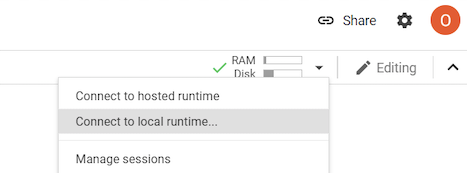

Having connected to the EPI2ME Labs Server, before anything else we will create and set a working directory:

In [ ]:
# create a work directory and move into it
tutorial_name = "pychopper_tutorial"
working_dir = '/epi2melabs/{}'.format(tutorial_name)
!mkdir -p "$working_dir"
%cd "$working_dir"

from epi2melabs import ping
pinger = ping.Pingu()
_ = pinger.send_notebook_ping('start', 'pychopper_tutorial')

### Sample Data

To get started we will download a sample sequencing dataset. There are two options available:

* *small set*: a simple set of four reads to test functionality
* *D. melanogaster*: a modest fruit fly dataset to explore with pychopper

The form below will download either dataset and save them as `sample_data.fastq`. To start the download click on the cell and then press Command/Ctrl-Enter, or click the Play symbol to the left-hand side.

In [ ]:
#@markdown Select download type and press Play
bucket = "ont-exd-int-s3-euwst1-epi2me-labs"
domain = "s3-eu-west-1.amazonaws.com"
site = "https://{}.{}".format(bucket, domain)

download = "D. melanogaster" #@param ["D. melanogaster", "small set"]

## download the data
location="{}/pychopper_tutorial".format(site)
filename = None
if download == "D. melanogaster":
    filename = "Dmel.4.filt.fastq.gz"
elif download == "small set":
    filename = "small_cdna_example.fastq.gz"
if filename is not None:
    !echo "Downloading $filename"
    !wget -O sample_data.fastq.gz "$location"/"$filename"
    !echo "Extracting"
    !gunzip -f sample_data.fastq.gz
    !echo "Done"
else:
    print("Dataset not recognised.")

To view the outcome of the download we can use the `tree` command to show the contents of the working directory:

In [ ]:
!tree .

.
└── sample_data.fastq

0 directories, 1 file


The files should also appear in the File Browser to the left-hand side of the screen.

### Using your own data

If you wish to analyse your own data rather than the sample data, you can edit the value of the `input_file` variable below. To find the correct full path of a file you can navigate to it in the `Files` browser to the left-hand side, right-click on the file and select `Copy path`:

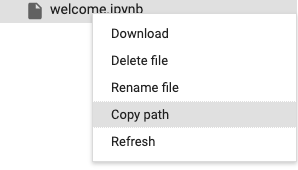

The location shared with the EPI2ME labs server from your computer will show as `/epi2melabs`, for example a file located at `/data/my_gridion_run/fastq_pass` on your computer will appear as `/epi2melabs/my_gridion_run/fastq_pass` when it is the `/data` folder that is shared.

### Data entry

Having downloaded the sample data, or locating your own data in the file browser, we need to provide the filepaths as input to the notebook. This is done in the form below, after updating the values, be sure to press the play button.



> **If you want simply to plot all the graphs in this tutorial for your dataset, rather than working through the tutorial, select `Run after` from the `Runtime` menu above after executing the cell below.**

In [8]:
#@markdown Enter the paths to you input files and output folder here. The input data may be either a a single fastq, compressed or otherwise, file or a directory containing multiple such files:
import os

# set variables for our inputs
input_data = '/epi2melabs/pychopper_tutorial/sample_data.fastq'  #@param {type: "string"}
output_folder = 'analysis'  #@param {type: "string"}
input_file = os.path.join(output_folder, "input.fastq")

# run a command to concatenate all the files together
!echo "Making output folder"
!mkdir -p "$output_folder"
!test -e "$input_data" && echo "Found input file." || "WARNING: $input_data does not exist"
!rationalize_fastq -i "$input_data" -o "$input_file"

Making output folder
Found input file.
Input: /epi2melabs/pychopper_tutorial/sample_data.fastq
Output: /epi2melabs/pychopper_tutorial/analysis/input.fastq
Single file detected.
- Creating symlink.
Created symlink /epi2melabs/pychopper_tutorial/analysis/input.fastq


## Running pychopper

Pychopper consists of a single program `cdna_classifier.py` to identify, orient and trim full-length Nanopore cDNA reads.

To run pychopper in a basic mode we need to give simply an input and output `.fastq`. Pychopper first identifies alignment hits of sequencing primers across the length of the sequence reads. The default method for doing this is using nhmmscan with pre-trained strand specific [profile HMMs](https://www.ebi.ac.uk/training/online/course/pfam-database-creating-protein-families/what-are-profile-hidden-markov-models-hmms). Alternatively, one can use the [edlib](https://github.com/Martinsos/edlib) backend, which uses a combination of global and local alignment to identify the primers within the read.

After identifying the primer hits, the reads are divided into segments defined by two consecutive primer hits. Segments are given a score based on their length, provided that the flanking primer hits are valid. When the primer hits are invalid a zero score is assigned to the segment.

The segments are assigned to reads using a dynamic programming algorithm maximizing the sum of used segment scores.

To run `cdna_classifier.py` on the input file specified above execute the cell below. For the D. Melanogaster sample dataset this will take around 10 minutes.

In [9]:
!cdna_classifier.py \
    -r "$output_folder"/report.pdf \
    -u "$output_folder"/unclassified.fq \
    -w "$output_folder"/rescued.fq \
    -S "$output_folder"/cdna_classifier_report.tsv \
    "$input_file" \
    "$output_folder"/full_length_output.fq

Configurations to consider: "+:SSP,-VNP|-:VNP,-SSP"
Counting fastq records in input file: analysis/input.fastq
Total fastq records in input file: 15076
Tuning the cutoff parameter (q) on 10064 sampled reads (66.3%) passing quality filters (Q >= 7.0).
Optimizing over 30 cutoff values.
100%|███████████████████████████████████████████| 30/30 [11:28<00:00, 22.96s/it]
Best cutoff (q) value is 0.5173 with 81% of the reads classified.
Processing the whole dataset using a batch size of 1884:
100%|████████████████████████████████████| 15076/15076 [00:43<00:00, 344.75it/s]
Finished processing file: analysis/input.fastq
Input reads failing mean quality filter (Q < 7.0): 0 (0.00%)
Output fragments failing length filter (length < 50): 0
Detected 1 potential artefactual primer configurations:
Configuration	NrReads	PercentReads
VNP,SSP,-SSP	152	1.01%


### Analysis of pychopper results

To evaluate the results of pychopper the code box below will summarise the
classification of reads. It will also display a plot illustrating the selection
of the classification decision boundary. This plot should be unimodal (have a single peak).

In [10]:
#@markdown Classification summary *(click to show)*
import os
import pandas as pd
import aplanat
from aplanat import lines

pinger.send_notebook_ping('stop', 'pychopper_tutorial')

csv = os.path.join(output_folder, "cdna_classifier_report.tsv")

df = pd.read_csv(csv, sep="\t", index_col="Name")
classified = df.loc[df["Category"] == "Classification"] \
    .copy().reset_index().rename(columns={'Name': 'Classification'})
classified["Percentage"] = 100 * classified["Value"] / classified["Value"].sum()
display(classified[['Classification', 'Percentage',]])

tuning =  df.loc[df["Category"] == "AutotuneSample"] \
    .copy().reset_index().rename(columns={'Name': 'Filter'})
plot = lines.line(
    [tuning['Filter'].astype(float)], [tuning['Value']],
    title="Cut off parameter selection curve",
    x_axis_label='Filter cut off',
    y_axis_label='Selected reads')
aplanat.show(plot)

,Classification,Percentage
0,Primers_found,80.322813
1,Rescue,2.125845
2,Unusable,17.551342
